# Dataset Exploration

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data-2025-01.csv')
df.head()

,game_id,white_elo,black_elo,opening,winner
0,1,1657,1610,Bishop's Opening: Berlin Defense,2
1,2,971,1093,Queen's Gambit Declined: Albin Countergambit,2
2,3,1693,1698,Mikenas Defense,2
3,4,1759,1704,"French Defense: Tarrasch Variation, Guimard De...",1
4,5,1137,1184,French Defense: Queen's Knight,2


## ELOs analysieren

In [26]:
df['avg_elo'] = df[['white_elo', 'black_elo']].mean(axis=1)

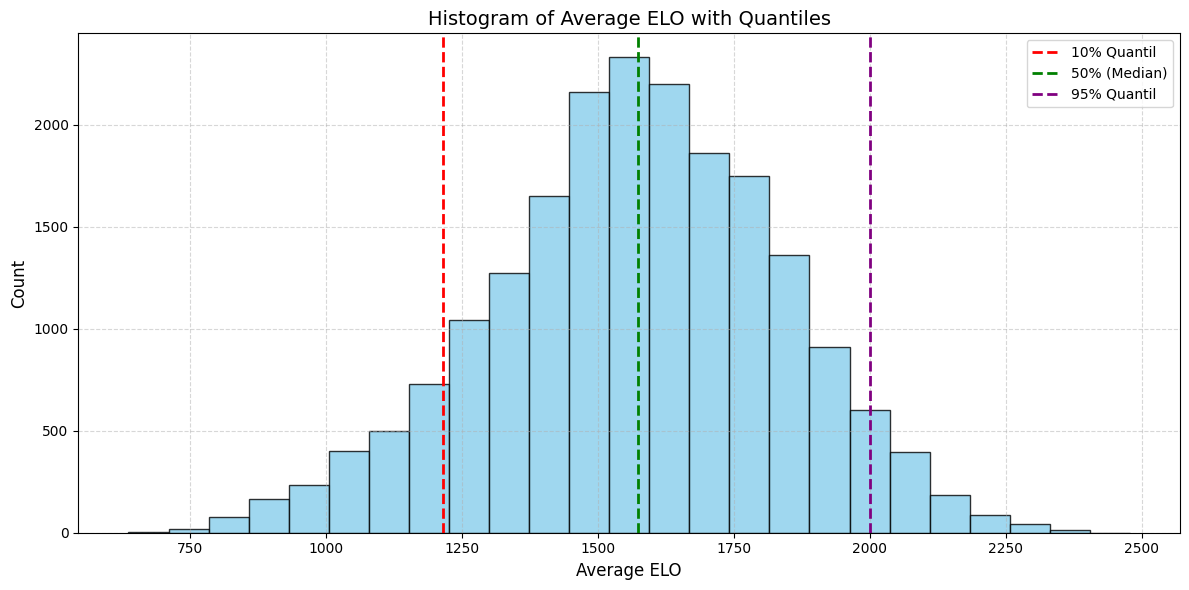

In [27]:
q1 = df['avg_elo'].quantile(0.10)
q2 = df['avg_elo'].quantile(0.5)
q3 = df['avg_elo'].quantile(0.95)

plt.figure(figsize=(12, 6))
plt.hist(df['avg_elo'], bins=25, color='skyblue', edgecolor='black', alpha=0.8)

plt.axvline(q1, color='red', linestyle='--', linewidth=2, label='10% Quantil')
plt.axvline(q2, color='green', linestyle='--', linewidth=2, label='50% (Median)')
plt.axvline(q3, color='purple', linestyle='--', linewidth=2, label='95% Quantil')

plt.xlabel('Average ELO', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Average ELO with Quantiles', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
def elo_group(elo):
    if elo < q1:
        return "Beginner"
    elif elo < q2:
        return "Intermediate"
    elif elo < q3:
        return "Advanced"
    else:
        return "Expert"


df['elo_group'] = df['avg_elo'].apply(elo_group)
df.head()

,game_id,white_elo,black_elo,opening,winner,avg_elo,elo_group
0,1,1657,1610,Bishop's Opening: Berlin Defense,2,1633.5,Advanced
1,2,971,1093,Queen's Gambit Declined: Albin Countergambit,2,1032.0,Beginner
2,3,1693,1698,Mikenas Defense,2,1695.5,Advanced
3,4,1759,1704,"French Defense: Tarrasch Variation, Guimard De...",1,1731.5,Advanced
4,5,1137,1184,French Defense: Queen's Knight,2,1160.5,Beginner


## Globale Stats

In [29]:
counts = df.groupby('elo_group')['winner'].value_counts(normalize=True).unstack(fill_value=0)
counts = counts.round(2)
counts = counts.rename(columns={
    0: "Remis",
    1: "Weiß gewinnt",
    2: "Schwarz gewinnt"
})
counts = counts.loc[["Beginner", "Intermediate", "Advanced", "Expert"]]

counts.head()

winner,Remis,Weiß gewinnt,Schwarz gewinnt
elo_group,,,
Beginner,0.06,0.48,0.46
Intermediate,0.04,0.49,0.46
Advanced,0.06,0.49,0.45
Expert,0.10,0.47,0.43


In [30]:
# GLOBAL best opening
summary = (
    df.groupby("opening")["winner"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "draw", 1: "white_wins", 2: "black_wins"})
)

summary["total_games"] = summary.sum(axis=1)
summary.reset_index(inplace=True)

summary["white_winrate"] = (summary.white_wins / summary.total_games).round(2)
summary["black_winrate"] = (summary.black_wins / summary.total_games).round(2)
summary["max_winrate"] = summary[["white_winrate", "black_winrate"]].max(axis=1)

summary = summary[summary['total_games'] > 100]
summary = summary[["opening", "total_games", "white_winrate", "black_winrate", "max_winrate"]]

summary.sort_values(by="max_winrate", ascending=False).head()

winner,opening,total_games,white_winrate,black_winrate,max_winrate
1026,Scotch Game,193,0.63,0.35,0.63
1018,Scandinavian Defense: Mieses-Kotroc Variation,181,0.60,0.36,0.60
883,Queen's Pawn Game: Accelerated London System,425,0.55,0.39,0.55
614,King's Pawn Game: Leonardis Variation,130,0.42,0.55,0.55
1187,Sicilian Defense: Old Sicilian,139,0.41,0.55,0.55


## Beste Openings für ELO-Gruppen bestimmen

In [31]:
summary = (
    df.groupby(["opening", "elo_group"])["winner"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "draw", 1: "white_wins", 2: "black_wins"})
)

summary["total_games"] = summary.sum(axis=1)
summary.reset_index(inplace=True)

summary["white_winrate"] = (summary.white_wins / summary.total_games).round(2)
summary["black_winrate"] = (summary.black_wins / summary.total_games).round(2)

summary = summary[summary['total_games'] > 100]
summary = summary[["opening", "elo_group", "total_games", "white_winrate", "black_winrate"]]

summary.head()

winner,opening,elo_group,total_games,white_winrate,black_winrate
206,Caro-Kann Defense,Advanced,135,0.42,0.50
209,Caro-Kann Defense,Intermediate,108,0.51,0.45
588,Four Knights Game: Italian Variation,Intermediate,157,0.45,0.50
854,Indian Defense,Advanced,130,0.40,0.50
922,Italian Game: Anti-Fried Liver Defense,Advanced,107,0.57,0.36


In [32]:
# Best Openings for White
idx = summary.groupby("elo_group")["white_winrate"].idxmax()
df_top_white_winrate = summary.loc[idx]
df_top_white_winrate.sort_values(by="white_winrate", ascending=False).head()

winner,opening,elo_group,total_games,white_winrate,black_winrate
922,Italian Game: Anti-Fried Liver Defense,Advanced,107,0.57,0.36
1810,Queen's Pawn Game: Accelerated London System,Intermediate,199,0.55,0.38


In [33]:
# Best Openings for Black
idx = summary.groupby("elo_group")["black_winrate"].idxmax()
df_top_black_winrate = summary.loc[idx]
df_top_black_winrate.sort_values(by="black_winrate", ascending=False).head()

winner,opening,elo_group,total_games,white_winrate,black_winrate
206,Caro-Kann Defense,Advanced,135,0.42,0.5
588,Four Knights Game: Italian Variation,Intermediate,157,0.45,0.5
